In [43]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install webrtcvad --user

  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 71kB 863kB/s ta 0:00:01
  Running setup.py bdist_wheel for webrtcvad ... done
  Stored in directory: /home/mpc6/.cache/pip/wheels/44/2a/18/bd1aec41cac7c3051fe95d92a6ed446122ea31dc713c432fa1
Successfully built webrtcvad
You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [26]:
import os, sys
#import soundfile as sf
import scipy.io.wavfile
from scipy.fftpack import dct
from scipy.io import wavfile
from librosa.core import resample
#import sounddevice as sd
#import librosa
import numpy as np
import glob
import matplotlib.pyplot as plt
from IPython.display import Audio
import thinkdsp
import subprocess
from subprocess import Popen, PIPE
#from sklearn.model_selection import train_test_split
#import pickle
# Keras packages model
#from keras.models import Sequential, Model, load_model
#from keras.layers import Input, Reshape, Dense, GRU, Convolution1D, Convolution2D, MaxPooling1D, MaxPooling2D, Dropout, BatchNormalization, Flatten, concatenate 
#from keras.callbacks import Callback, ModelCheckpoint, CSVLogger, EarlyStopping
#from keras import regularizers

SAMPLERATE = 8000
DATAPATH = 'data/test'


In [50]:
# Download raw data from source
# and uncompress to DATAPATH

os.makedirs(DATAPATH, exist_ok=True)

url = 'http://download.tensorflow.org/data/'
file_name = 'speech_commands_v0.01.tar.gz'

if not os.path.exists(DATAPATH):
    os.makdirs(DATAPATH)
        
if not os.path.exists(os.path.join(DATAPATH, file_name)):
    
    print('Downloading', file_name)
    rtnVal = subprocess.call(['wget', os.path.join(url,file_name), '-P', DATAPATH])
    assert rtnVal == 0, 'downloaded failed!'
    print(file_name, 'downloaded successfully')
    
    print('Uncompressing', os.path.basename(file_name))
    rtnVal = subprocess.call(['tar', '-C', DATAPATH, '-zxvf', os.path.join(DATAPATH, file_name)])
    assert rtnVal == 0, 'file failed to uncompress!'
    print(file_name, 'uncompressed successfully')

# save data at correct SAMPLERATE
for wav_file in glob.iglob(os.path.join(DATAPATH, '*', '*.wav')):
    #print('File:', wav_file)
    samples, sample_rate = sf.read(wave_file)
    
    if sample_rate != SAMPLERATE:
        print('Resampling file ', wav_file, 'from', sample_rate, 'to', SAMPLERATE)
        samples = resample(samples, sample_rate, SAMPLERATE)
        sf.write(wav_file, samples, SAMPLERATE)    
        
print('Data downloaded and resampled to', SAMPLERATE, 'Hz')

Data downloaded and resampled to 8000 Hz


8000


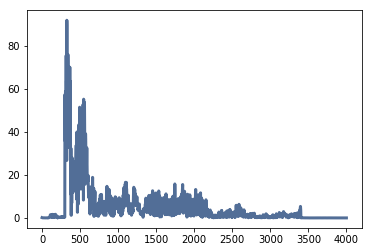

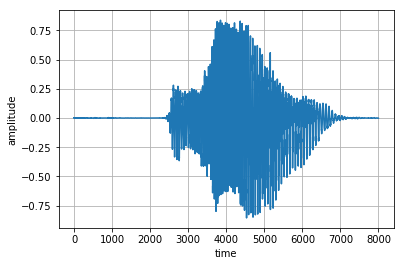

In [55]:
#Examine a wave's spectrum
high_cutoff = 3400
low_cutoff = 300

#waveFile = 'data/trainingNums/05_620a81c69b-VAD.wav'
wave_file = 'data/test/bed/00176480_nohash_0.wav'
samples, sample_rate = sf.read(wave_file)
print(sample_rate)

if sample_rate != SAMPLERATE:
    samples = resample(samples, sample_rate, SAMPLERATE)
    
plt.figure()
sample = thinkdsp.read_wave(wave_file)
spectrum = sample.make_spectrum()
spectrum.low_pass(cutoff=high_cutoff, factor=0.01)
spectrum.high_pass(cutoff=low_cutoff, factor=0.01)

spectrum.plot()
plt.figure()
plt.plot(samples)
plt.xlabel('time')
plt.ylabel('amplitude')
#plt.yscale('log')
plt.grid(True)

Audio(samples, rate=SAMPLERATE)




In [ ]:
wave_file = 'data/zero/6c968bd9_nohash_0.wav'
samples, sample_rate = sf.read(wave_file)

if sample_rate != SAMPLERATE:
    samples = resample(samples, sample_rate, SAMPLERATE)
    
pre_emphasis = 0.97  # coeffecient for pre-emphasis filter, boost high end for cleaner FFT
emphasized_signal = np.append(samples[0], samples[1:] - pre_emphasis * samples[:-1])

# test pre-empahsis filter (view and hear)
plt.figure()
plt.plot(samples)
plt.xlabel('time')
plt.ylabel('amplitude')
#plt.yscale('log')
plt.grid(True)

Audio(samples, rate=SAMPLERATE)

# set up frames for FFTs 
frame_size = 0.025
frame_stride = 0.01

signal_length = len(emphasized_signal)
frame_length = int(round(frame_size * SAMPLERATE))
frame_step = int(round(frame_stride * SAMPLERATE))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)/frame_step)))

In [ ]:
frame_size = 0.025
frame_stride = 0.01

signal_length = len(emphasized_signal)
frame_length = int(round(frame_size * SAMPLERATE))
frame_step = int(round(frame_stride * SAMPLERATE))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)/frame_step)))

8000
8000


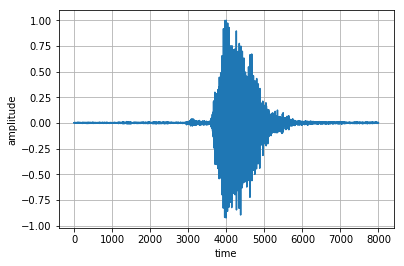

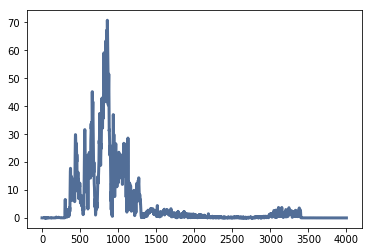

In [84]:
# load a wave, plot and play
fileName = 'data/filteredNums/12_cc5336bbc0.wav' 
#fileName = 'data/trainingNums/06_1507906720.wav'
fileName = 'data/tst_numbers_test2/cb2b6b25ca.wav'
#fileName = 'data/trainingNums2/12_a398641269.wav'
#fileName = 'data/trainingNums4/11_817144b701.wav'
#fileName = 'data/numbers/11_5589b5726b.wav'

data, sample_rate = sf.read(fileName)
print(sample_rate)
print(len(data))
duration = len(data)//5
#print(duration)
#print(max(data), min(data))
# test clip from max energy out
#maxEnergy = np.argmax(data)
#data = data[maxEnergy-(SAMPLERATE//2):maxEnergy+(SAMPLERATE//2)]
#print('new num samples', len(data))
frameSize = 6000
#data = highest_energy_frame(data, frameSize)
#print(len(data))

plt.figure()
plt.plot(data)
plt.xlabel('time')
plt.ylabel('amplitude')
#plt.yscale('log')
plt.grid(True)

plt.figure()
sample = thinkdsp.read_wave(fileName)
spectrum = sample.make_spectrum()
spectrum.plot()
#mags = abs(np.real(np.fft.rfft(data[:duration])))
#print(mags.shape)
#plt.figure()
#plt.plot(mags)
#plt.xlabel('freq')
#plt.ylabel('amplitude')
#plt.yscale('log')
#plt.grid(True)

#clippedSamples = clip_audio(data)
Audio(data, rate=sample_rate)